In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import json
import urllib
from pathlib import Path
from collections import defaultdict

In [58]:
import numpy as np
import pandas as pd
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

In [4]:
import torch
from torch import optim

In [43]:
# fast.ai explicit dependencies
from fastai.conv_learner import ConvLearner, resnet34
from fastai.conv_learner import tfms_from_model, CropType
from fastai.dataset import ImageClassifierData, to_np, get_cv_idxs, split_by_idx

In [6]:
torch.cuda.device(0)

In [7]:
plt.ion()

In [8]:
PATH        = Path.home() / 'data' / 'voc2007'
JPEG        = Path('VOCdevkit/VOC2007/JPEGImages') 
IMAGES      = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES  = 'categories'
FILE_NAME   = 'file_name'
ID          = 'id'
BBOX        = 'bbox'
IMG_ID      = 'image_id'
CAT_ID      = 'category_id'

In [9]:
def parse_annotations(arr):
    parsed = defaultdict(list)
    for annot in arr:
        if annot['ignore']:
            continue
        bbox_raw = annot[BBOX]
        bbox_hw = from_voc(bbox_raw)
        parsed[annot[IMG_ID]].append((bbox_hw, annot[CAT_ID]))
    return dict(parsed)


def from_voc(bbox):
    """
    Converts Pascal bounding box from (x, y, w, h) into
    (top, left, bottom, right) format, and switch x/y coordinates to
    make a converted array indexes consistent with Numpy.
    """
    x, y, w, h = bbox
    new_box = [y, x, y + h - 1, x + w - 1]
    return np.array(new_box)


def to_voc(bbox):
    top, left, bottom, right = bbox
    new_box = [left, top, right - left + 1, bottom - top + 1]
    return np.array(new_box)

In [10]:
with open(PATH / 'pascal_train2007.json') as file:
    train_json = json.load(file)

categories = {obj[ID]: obj['name'] for obj in train_json[CATEGORIES]}
train_files = {obj[ID]: obj[FILE_NAME] for obj in train_json[IMAGES]}
train_indexes = [obj[ID] for obj in train_json[IMAGES]]
train_annotations = parse_annotations(train_json[ANNOTATIONS])

In [11]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized
        to range between 0.0 - 1.0

    """
    flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None:
                raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [25]:
class ImagePlotter:
    """Helper class visualizing the dataset's images."""
    
    def __init__(self, root, annotations, files, categories, **fig_kwargs):
        self.root = root
        self.annotations = annotations
        self.files = files
        self.categories = categories
        self.fig_kwargs = fig_kwargs
        
    def show(self, index, ax=None):
        self.draw(index, ax)
        plt.show()
        
    def draw(self, index, ax=None):
        annotation = self.annotations[index]
        image = open_image(self.root / self.files[index])
        ax = self.draw_image(image, ax=ax)
        for bbox, category in annotation:
            bbox = to_voc(bbox)
            classes = self.categories[category]
            self.draw_rect(ax, bbox)
            self.draw_text(ax, bbox[:2], classes, size=16)
        return ax
    
    def show_images(self, images, targets, class_names, dims=(3, 4), figsize=(12, 12), grid=True):
        fig, axes = plt.subplots(*dims, figsize=figsize)
        for i, ax in enumerate(axes.flat):
            image = images[i]
            [non_zero] = np.nonzero(targets[i] > 0.4)
            self.draw_image(image, ax=ax, grid=grid)
            if len(non_zero) > 0:
                classes = '\n'.join([class_names[index] for index in non_zero])
                self.draw_text(ax, (0, 0), classes)
            else:
                classes = '<NONE>'
                self.draw_text(ax, (0, 0), classes, color='salmon')
        plt.tight_layout()
        plt.show()
        
    def draw_image(self, image, grid=False, n_cells=8, ax=None):
        if not ax:
            fig, ax = plt.subplots(**self.fig_kwargs)
        ax.imshow(image)
        if grid:
            width, height = image.shape[:2]
            ax.set_xticks(np.linspace(0, width, n_cells))
            ax.set_yticks(np.linspace(0, height, n_cells))
            ax.grid()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        return ax
    
    def draw_outline(self, obj, lw=4):
        effects = [
            patheffects.Stroke(linewidth=lw, foreground='black'),
            patheffects.Normal()]
        obj.set_path_effects(effects)
        
    def draw_rect(self, ax, bbox, lw=4, color='white'):
        rect = patches.Rectangle(
            bbox[:2], *bbox[-2:],
            fill=False, edgecolor=color, lw=2)
        patch = ax.add_patch(rect)
        self.draw_outline(patch, lw)
        
    def draw_text(self, ax, xy, text, size=14, outline=1, color='white'):
        text = ax.text(
            *xy, text, 
            va='top', color=color,
            fontsize=size, weight='bold')
        self.draw_outline(text, outline)

In [26]:
plotter = ImagePlotter(PATH / JPEG, train_annotations, train_files, categories)

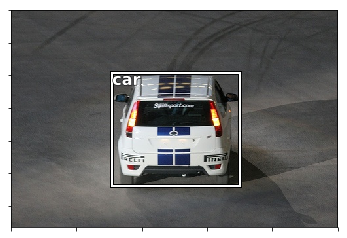

In [14]:
plotter.draw(12)

In [15]:
factory = resnet34
batch_size = 64
CSV = PATH / 'tmp' / 'mc.csv'

In [16]:
transforms = tfms_from_model(factory, 224, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, JPEG, CSV, tfms=transforms, bs=batch_size)
learner = ConvLearner.pretrained(factory, data)
learner.opt_fn = optim.Adam

In [17]:
lr = 2e-2
learner.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.317853   0.128807   0.9594    
    1      0.170117   0.079192   0.9731                    
    2      0.114599   0.075188   0.975                     



[0.07518777194619179, 0.9750000081062317]

In [18]:
lrs = np.array([lr/100, lr/10, lr])
learner.freeze_to(-2)
learner.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.072487   0.07362    0.9733    
    1      0.054048   0.075955   0.9749                     
    2      0.038455   0.082654   0.9731                     
    3      0.026976   0.077639   0.9753                     
    4      0.019862   0.07721    0.9754                     



[0.0772099711894989, 0.9754000096321106]

In [19]:
y = learner.predict()
x, _ = next(iter(data.val_dl))
x = to_np(x)
images = data.val_ds.denorm(x)

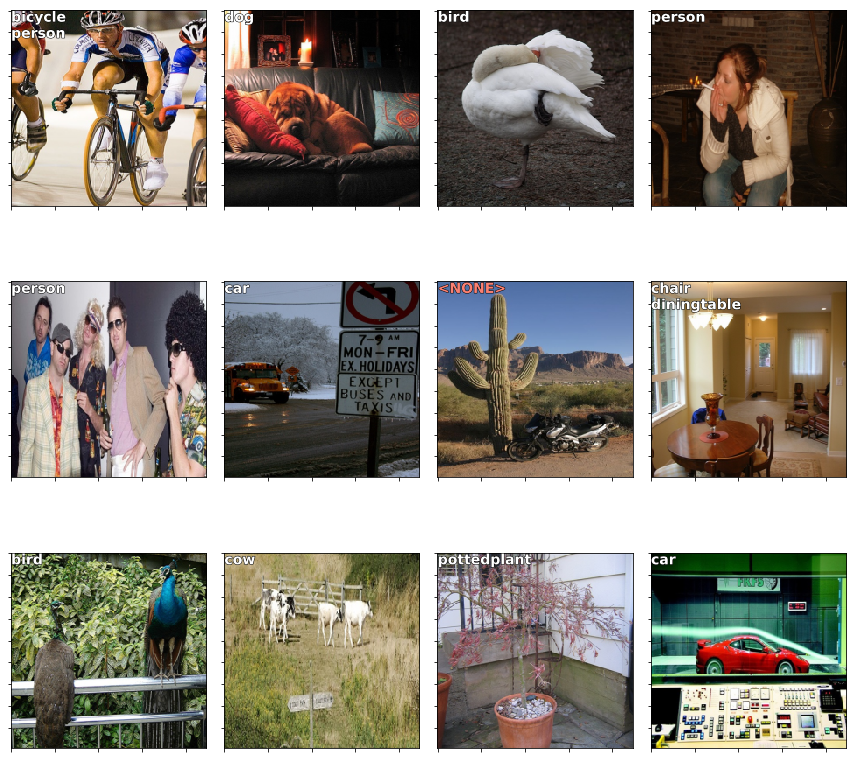

In [27]:
plotter.show_images(images, y, data.classes, grid=False)

## Bounding Box per Cell

In [29]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

factory = resnet34
size = 224
batch_size = 64

In [56]:
multi_class = [
    [categories[an[1]] for an in train_annotations[index]] 
    for index in train_indexes]

multi_class_bb = [
    np.concatenate([an[0] for an in train_annotations[index]])
    for index in train_indexes]

multi_class_strings = [
    ' '.join(str(digit) for digit in box)
    for box in multi_class_bb]

In [48]:
id2cat = list(categories.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
multi_class_ids = np.array([
    np.array([cat2id[cls] for cls in class_list])
    for class_list in multi_class])

In [49]:
val_indexes = get_cv_idxs(len(train_files))
((val_mc, train_mc), ) = split_by_idx(val_indexes, multi_class_ids)

In [59]:
df = pd.DataFrame({
    'fn': [train_files[i] for i in train_indexes],
    'bbox': multi_class_strings
}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)